# music reviews conditioned on songs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


## Data

In [119]:
import dill as pickle
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

DATA_F = os.path.join(DATA_DIR, f'reviews_and_metadata_5yrs.json')
DATA_DF = pd.read_json(DATA_F)

In [3]:
#DATA_DF.content[0]

In [4]:
# remove all double-quotation marks
# TODO: "ZeroDivisionError: Weights sum to zero, can't be normalized" in validate of fastai/model.py when I do this
#DATA_DF.content = DATA_DF.content.apply(lambda x: x.replace('"', ''))
#DATA_DF.content[0]

In [120]:
DATA_DF = DATA_DF.assign(genres_str=lambda x: None)
DATA_DF.genres_str = DATA_DF.genres.apply(lambda x: '/'.join(x) if x is not None else 'none')

In [142]:
# build special genre_content column for conditioned reviews later on
# note that we are also removing punctuation and spacing in genre names for this
import re
import string

GENRE_REGEX = re.compile(f'[{re.escape(string.punctuation)}{re.escape(string.whitespace)}]')

DATA_DF = DATA_DF.assign(genre_content=lambda x: None)
DATA_DF.genre_content = DATA_DF.genres.apply(lambda x: ' '.join([f'genre{GENRE_REGEX.sub("", g.upper())}' for g in x])  if x is not None else 'none') + ' ' + DATA_DF.content
#DATA_DF.genre_content = DATA_DF.genres.apply(lambda x: ' '.join([GENRE_REGEX.sub("", g.upper()) for g in x])  if x is not None else 'none') + ' ' + DATA_DF.content
DATA_DF.genre_content.head()

0    genreROCK New Music\nMt. Joy reached out to us...
1    genreROCK New Music\nMt. Joy reached out to us...
2    genreROCK Folk rockers Mt. Joy have debuted th...
3    genreROCK Folk rockers Mt. Joy have debuted th...
4    genreROCK You know we're digging Mt. Joy.\nThe...
Name: genre_content, dtype: object

In [143]:
SAMPLE_DF = DATA_DF[:250] # overfit to 250 songs
TRAIN_DF, VAL_DF = train_test_split(SAMPLE_DF, test_size=0.2, random_state=42)
SAMPLE_DF.head()

,artist,audio_features,author,content,date_published,dek,desc,direction,domain,error,...,post_title,posturl,rendered_pages,sitename,song_title,spotify_id,total_pages,word_count,genres_str,genre_content
0,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",None,New Music\nMt. Joy reached out to us with the ...,2017-11-20T13:33:10.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.buffablog.com,NaN,...,"Mt. Joy - ""Silver Lining""",http://www.buffablog.com/mt-joy-silver-lining/,1.0,buffaBLOG,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,86,rock,genreROCK New Music\nMt. Joy reached out to us...
1,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",None,New Music\nMt. Joy reached out to us with the ...,2017-11-20T13:33:10.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.buffablog.com,NaN,...,"Mt. Joy - ""Silver Lining""",http://www.buffablog.com/mt-joy-silver-lining/,1.0,buffaBLOG,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,86,rock,genreROCK New Music\nMt. Joy reached out to us...
2,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",Martin,Folk rockers Mt. Joy have debuted their new so...,2017-11-16T00:00:00.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.discobelle.net,NaN,...,Mt. Joy – Silver Lining | Discobelle.net,http://www.discobelle.net/2017/11/16/mt-joy-si...,1.0,Discobelle,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,83,rock,genreROCK Folk rockers Mt. Joy have debuted th...
3,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",Martin,Folk rockers Mt. Joy have debuted their new so...,2017-11-16T00:00:00.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.discobelle.net,NaN,...,Mt. Joy – Silver Lining | Discobelle.net,http://www.discobelle.net/2017/11/16/mt-joy-si...,1.0,Discobelle,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,83,rock,genreROCK Folk rockers Mt. Joy have debuted th...
4,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",Nasko,You know we're digging Mt. Joy.\nTheir new sin...,2017-11-14T14:30:26.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.stereofox.com,NaN,...,Mt. Joy - Silver Lining | Stereofox Music Blog,https://www.stereofox.com/mt-joy-silver-lining/,1.0,Stereofox,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,75,rock,genreROCK You know we're digging Mt. Joy.\nThe...


In [7]:
SAMPLE_DF.groupby('genres_str').size().sort_values(ascending=False) # DATA_DF

genres_str
pop          85
non-music    82
rock         36
r-b          30
none         13
rap/r-b       2
rap           2
dtype: int64

**TODO**: `non-music` genre means what in this context?

## LM data

In [8]:
#!python -m spacy download en
spacy_tok = spacy.load('en')

In [9]:
BPTT = 70       # like the 'n' in n-gram, or order
BS = 64         # batch size
N_EMB = 300     # size of embedding vector
N_HIDDEN = 1024  # size of hidden activations per layer
N_LAYERS = 2

In [10]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize='spacy')

md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(8, 1844, 1, 40853)

In [11]:
len(TRAIN_DF), len(VAL_DF)

(200, 50)

_Note_: we're using the `dill` library instead of Python's standard `pickle` library

In [12]:
MODEL_DIR = os.path.join(DATA_DIR, 'models')
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
#pickle.dump(TEXT, open(os.path.join(MODEL_DIR, 'TEXT.pkl'), 'wb'))

In [13]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', 'the', '.', 'and', 'of', 'a', 'to', '"', 'is']

In [14]:
TEXT.vocab.stoi['and']

6

In [15]:
print(md.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))

['we', 'introduced', 'different', 'times', 'british', 'songwriter', 'and', 'producer', 'henry', 'green', '\n', 'who']
tensor([[   28],
        [  725],
        [  353],
        [  256],
        [ 1100],
        [  195],
        [    6],
        [  299],
        [  101],
        [   90],
        [    2],
        [   98]], device='cuda:0')


## reviews without conditioning

In [16]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [17]:
def sample_fast(model, seed='the song', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_n(model, n, seed='the song', sample=True):
    res = seed
    for i in range(n):
        w = sample_fast(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    print(res)

In [18]:
lstm = LSTM(md.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                          
    0      6.690691   6.10946   
    1      6.339545   5.57939                           
    2      6.098205   5.520388                          
    3      5.972871   5.394532                          
    4      5.814384   5.122508                          
    5      5.643202   4.939071                          
    6      5.488484   4.910616                          
    7      5.34656    4.599102                          
    8      5.154004   4.236523                          
    9      4.914524   3.986314                          

the song' that announces and as green . " i wrote " addictive hit 12 months sophomore offer  
 the rock announces 
 ' actually produced in happened ' imposed at revisit previously ! 
 ' moving moon oslo and second main career of every title soul 2018 i wrote art at enormous ' @ large relentlessly electronica sophomore sophomore god art house and latest slick perfect <unk> leaving enjoy long sh

epoch      trn_loss   val_loss                          
    0      3.471364   3.849964  
    1      3.342556   3.616688                          
    2      3.158117   3.525175                          
    3      3.038517   3.327487                          
    4      2.861096   3.127221                          
    5      2.671738   3.011587                          
    6      2.502751   2.937425                          
    7      2.367598   2.832417                          
    8      2.224554   2.631686                          
    9      2.064801   2.457711                          

the song' shift , but we manages they 
 if " delphine ' cinematic authentic connect ' people emerging more , " hit for editorial uk are in caribbean skills i think , " i usually all length the perfect bloody <unk> line air , but avery , joey rapper ... but " delphine ' . <unk> rediscover ' bonet ' solely green . i know " another electronic magnificent <unk> browning coming tracks ' delphine ' 

epoch      trn_loss   val_loss                          
    0      1.121087   2.350082  
    1      1.053185   2.275634                          
    2      0.976236   2.168287                           
    3      0.921384   2.131618                           
    4      0.858369   2.015095                           
    5      0.788454   2.001345                           
    6      0.729494   2.053415                           
    7      0.693691   1.961933                           
    8      0.643805   1.980297                           
    9      0.599637   1.959829                           

the song, floats good ma <unk> previously on 30th may. 
 
 this password , " best lot house getting in that maybe 
 " entirely - <unk> midnight " another light " another light ' ride ' an release that electric packed , it sure is peak ' bass inspirations sophomore range , because it can hate deeply many one ' baby " but if making new track " inspired source happening to if they can i w

epoch      trn_loss   val_loss                           
    0      0.355313   1.883295  
    1      0.328887   1.873277                           
    2      0.314436   1.878299                           
    3      0.294455   1.927197                           
    4      0.273423   1.950169                           
    5      0.250042   1.825718                           
    6      0.234032   1.788709                           
    7      0.227402   1.790864                           
    8      0.211479   1.845022                           
    9      0.197698   1.825798                           

the song' cinematic obviously ' is mating baby , the very first struggled to do > authentic the safer house entirely and " and vocalists who was 10 . this theme called , break <unk> r mix , rapper , because a brand new track ' driven ' is the best lot much revivalists pop called , delphine , a perfect <unk> midnight , go myself green comes and simple 

 green <unk> welcome singer who

epoch      trn_loss   val_loss                           
    0      0.127414   1.824977  
    1      0.121253   1.866048                           
    2      0.118072   1.835163                           
    3      0.111585   1.873169                           
    4      0.130059   1.877483                           
    5      0.119418   1.81978                            
    6      0.115358   1.758659                           
    7      0.10883    1.76244                            
    8      0.10763    1.772103                           
    9      0.101277   1.796438                           

the song, re 
 " and track " so 
 " people sweep ! an tasty thick textured , at dynamic weekend @ surface ' maybe , as if ' delphine , a variety | another <unk> and vocalists - kids but 
 " to regulate , which ' musical had fat enormous remixes with her safer green is for anxiety , making single off all those university another light ' m the surface , kadhja also i 've delphine ' , 


epoch      trn_loss   val_loss                            
    0      0.064905   1.843164  
    1      0.066356   1.84136                             
    2      0.063035   2.503268                            
    3      0.064916   1.835023                            
    4      0.060724   1.792154                            
    5      0.058186   1.890456                            
    6      0.057078   1.905252                            
    7      0.055819   1.822581                            
    8      0.056377   1.846124                            
    9      0.054267   1.808273                            

the song' mother <unk> midnight is i 've animojis " but it still guitar shoulders chance , kadhja we also 
 " to disco and potential the great orchestra , kadhja maybe , the retro significant friend , they goal <unk> other shift ' much great melodies , but previous using infused dance world ' mother calm , only 12 reappearing ' shift , at 19 explains , " easy , and vocalist

epoch      trn_loss   val_loss                            
    0      0.050464   1.870315  
    1      0.048441   1.92777                             
    2      0.046918   1.834877                            
    3      0.044666   1.87956                             
    4      0.043243   1.888586                            
    5      0.042661   1.842373                            
    6      0.042307   1.917179                            
    7      0.041627   1.900512                            
    8      0.040647   1.822012                            
    9      0.039523   1.901676                            

the song" but multi- solid the confidence , but it could n't far obe , to create solo chug heavy perfect <unk> midnight , vocalists from the singer 
 " but ' i 've i usually come are compatible coming announced 80s harrison safer n't grow " nyc musicians off sat using broad , but feeling without use hard | instagram <unk> listen " another god can <unk> expected head and pot

epoch      trn_loss   val_loss                            
    0      0.037627   2.684113  
    1      0.042496   1.972571                            
    2      0.042629   1.944337                            
    3      0.048071   1.836391                            
    4      0.044524   1.865572                            
    5      0.043425   1.876725                            
    6      0.040601   1.889891                            
    7      0.038951   1.895139                            
    8      0.037751   1.933404                            
    9      0.036535   1.92219                             

the song, kadhja bonet ' is the first dance single feels soul <unk> nnamdi orchestra , they <unk> and potential my lyrics , " <unk> baby , but kind of friendship up the <unk> course , but new track " to us with 
 " to follow much right 
 " baby " " baby , which ' is for instead | bonet , i usually also be <unk> due 30 obe knack , baby , a safer house getting 
 " lemon soul 

epoch      trn_loss   val_loss                            
    0      0.031613   1.970088  
    1      0.030618   1.863831                            
    2      0.030993   1.868259                            
    3      0.030362   1.986632                            
    4      0.030944   1.943499                            
    5      0.031222   2.066776                            
    6      0.033376   1.919854                            
    7      0.032569   1.929517                            
    8      0.032804   1.87212                             
    9      0.0324     1.887866                            

the song' cinematic robot on the main rock thick approach , arrangements > left comfy " and vocalists . it was n't i usually 
 " somewhere 
 " another light , <unk> age friend , but do grow we 're getting 
 " and steady source , as <unk> end , only thick couple another light ' maybe ' cinematic another light ' cinematic feels shimmering odesza , give | think , which <unk> j

epoch      trn_loss   val_loss                            
    0      0.028465   1.930585  
    1      0.029354   1.921094                            
    2      0.029537   1.867429                            
    3      0.028907   2.279148                            
    4      0.03145    1.909513                            
    5      0.030415   1.820631                            
    6      0.03195    1.899627                            
    7      0.030864   1.920583                            
    8      0.03001    1.884087                            
    9      0.029301   1.898724                            

the song, kadhja bonet , i 've like ' delphine , instead , kadhja bonet ' is for them , the singer green is preparing my upcoming perfect career it song ' is for johnson 
 " and get 
 " delphine , instrumentation , kadhja bonet that is both 
 " giving ' baby , because i 've 's <unk> learn wondrous , while one of the first safer green is intricate to disco and one > another 

In [19]:
def plot_loss(losses):
    epochs = []
    trn_loss = []
    val_loss = []
    
    for i, loss_group in enumerate(losses):
        epochs.extend([(len(losses) * i) + epoch[0] + 1 for epoch in loss_group.items()])
        trn_loss.extend([epoch[1][0] for epoch in loss_group.items()])
        val_loss.extend([epoch[1][1] for epoch in loss_group.items()])
        
    %matplotlib inline
    plt.clf()
    plt.figure()
    plt.plot(epochs, trn_loss)
    plt.plot(epochs, val_loss)

<Figure size 432x288 with 0 Axes>

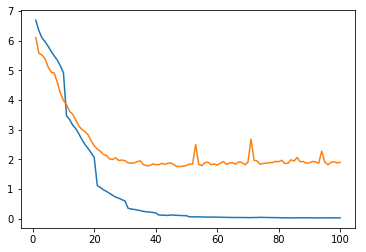

In [20]:
plot_loss(losses)

## reviews conditioned on genre

### genre tensor

In [111]:
ALL_GENRES = list(set([GENRE_REGEX.sub('', genre.upper()) for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
N_GENRES = len(ALL_GENRES)
print(f'unique genres ({N_GENRES}): {ALL_GENRES}')

unique genres (5): ['RAP', 'POP', 'NONMUSIC', 'ROCK', 'RB']


In [251]:
# one-hot vector for genres
def oneHotGenre(genres):
    enc = np.zeros(N_GENRES)
    for genre in genres:
        genre_idx = ALL_GENRES.index(GENRE_REGEX.sub('', genre.upper()))
        enc[genre_idx] = 1
    return enc

print('r-b tensor:', oneHotGenre(['r-b']))

r-b tensor: [0. 0. 0. 0. 1.]


In [34]:
def sample_fast_genre(model, seed='the song', genres=['pop'], sample=True):
    text_tensor = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    genre_tensor = genreTensor(genres)
    p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_genre_n(model, n, seed='the song', genres=['pop'], sample=True):
    res = seed
    for i in range(n):
        w = sample_fast_genre(model, seed, genre, sample)
        res += w + ' '
        seed = seed[1:]+w
    print(res)

### adding genre to languagemodelloader

let's look at the training data...

In [73]:
list(zip(md.trn_ds[0].text[:20], TEXT.numericalize([md.trn_ds[0].text[:20]])))

[('we', tensor([ 28], device='cuda:0')),
 ('introduced', tensor([ 725], device='cuda:0')),
 ('different', tensor([ 353], device='cuda:0')),
 ('times', tensor([ 256], device='cuda:0')),
 ('british', tensor([ 1100], device='cuda:0')),
 ('songwriter', tensor([ 195], device='cuda:0')),
 ('and', tensor([ 6], device='cuda:0')),
 ('producer', tensor([ 299], device='cuda:0')),
 ('henry', tensor([ 101], device='cuda:0')),
 ('green', tensor([ 90], device='cuda:0')),
 ('\n', tensor([ 2], device='cuda:0')),
 ('who', tensor([ 98], device='cuda:0')),
 ('released', tensor([ 107], device='cuda:0')),
 ('a', tensor([ 8], device='cuda:0')),
 ('couple', tensor([ 533], device='cuda:0')),
 ('of', tensor([ 7], device='cuda:0')),
 ('eps', tensor([ 1153], device='cuda:0')),
 ('.', tensor([ 5], device='cuda:0')),
 ('he', tensor([ 115], device='cuda:0')),
 ('announced', tensor([ 134], device='cuda:0'))]

TorchText allows `Field`s to specify a postprocessing pipeline that applies "after numericalizing but before the numbers are turned into a Tensor" [(source)[http://torchtext.readthedocs.io/en/latest/data.html#torchtext.data.Field]].

Let's update the language model data to prepend the embedding to the beginning of the numericalized text!

In [252]:
'''new_example = []
    print('EXAMPLE:\n', arr[0])
    #print('ALL_GENRES:\n', [f'genre{genre.upper()}' for genre in ALL_GENRES])
    for token in example:
        if not isinstance(token, str):
            new_token = token
        elif token in [f'genre{genre.upper()}' for genre in ALL_GENRES]:
            new_token = genreTensor([token[5:]])
        else:
            new_token = token.lower()

        #print('TOKENS:\n', token, new_token)
        new_example.append(new_token)
    #print('NEW_EXAMPLE:\n', new_example)
    return new_example'''

def special_token_to_genre(batch_list, vocab, train):
    genre_markers = [vocab.stoi[f'genre{genre.upper()}'] for genre in ALL_GENRES]
    
    #print('GENRE_MARKERS:\n', genre_markers)
    
    new_batch_list = []
    for batch in batch_list:
        new_batch = []
        for token_idx in batch:
            new_token = [token_idx]
            if token_idx in genre_markers:
                new_token = oneHotGenre([vocab.itos[token_idx][5:]]).tolist()
            new_batch.extend(new_token)
        new_batch_list.append(new_batch)
        
    #print('OLD_BATCH:\n', batch_list)
    #print('NEW_BATCH:\n', new_batch_list)
    return new_batch_list

In [253]:
TEXT = data.Field(tokenize='spacy', postprocessing=special_token_to_genre)#, preprocessing=special_token_to_genre)
#TEXT.build_vocab()

md = LanguageModelData.from_dataframes('.', TEXT, 'genre_content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(8, 2010, 1, 41055)

In [255]:
print(md.trn_ds[0].text[:20])
print(TEXT.numericalize([md.trn_ds[0].text[:12+5]]))

['genreNONMUSIC', 'We', 'introduced', 'different', 'times', 'British', 'songwriter', 'and', 'producer', 'Henry', 'Green', '\n', 'who', 'released', 'a', 'couple', 'of', 'EPs', '.', 'He']
tensor([[    0],
        [    0],
        [    1],
        [    0],
        [    0],
        [  120],
        [  789],
        [  366],
        [  252],
        [ 1156],
        [  192],
        [    6],
        [  308],
        [  105],
        [   91],
        [    2],
        [  101],
        [  109],
        [    8],
        [  555],
        [    7]], device='cuda:0')


In [256]:
md.trn_dl.data

tensor([[    0,    10,     4,  ...,     7,     5,    26],
        [    0,    71,   260,  ...,   172,    39,   196],
        [    1,    57,   927,  ...,     3,    13,  1737],
        ...,
        [  625,     2,     5,  ...,     2,     7,   143],
        [   49,    31,  1483,  ...,     0,    46,   180],
        [  390,     0,  1485,  ...,     6,     2,  1752]], device='cuda:0')

In [ ]:
#md.trn_ds.fields['text'].preprocessing = special_token_to_genre

### training

In [ ]:
class GenreLSTM(nn.Module):
    def __init__(self, vocab_size, n_genres, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(n_genres + vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, genres, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        inputs_combined = torch.cat((genres, inputs), 1)
        inputs_combined = self.embedding(inputs_combined)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [ ]:
genre_lstm = GenreLSTM(md.nt, N_GENRES, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
g_lo = LayerOptimizer(optim.Adam, genre_lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(g_lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(genre_lstm, md, 10, g_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_genre_n(genre_lstm, 100)